In [1]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
from torch import optim
from torch.nn import CrossEntropyLoss

In [2]:
from dqn import DQN
from torch.nn.functional import smooth_l1_loss
from mlnn import MLNN
from replay_memory import ReplayMemory, Transition
from training import optimize_dqn
import random

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
batch_size = 100
epochs = 200
input_dims = 784
hidden_dims = 333
output_dims = 10
gamma = 0.999
target_update = 10
len_train_dataset = len(train_loader.dataset)

In [7]:
n_layers = 3
n_width = 2

In [8]:
policy_net = DQN(hidden_dims, hidden_dims, n_width).cuda()
target_net = DQN(hidden_dims, hidden_dims, n_width).cuda()
model = MLNN(n_layers, n_width, input_dims, hidden_dims, output_dims)

In [9]:
memory_capacity = 100
replay_memory = ReplayMemory(memory_capacity)

In [10]:
optimizer = optim.Adam(model.parameters())
dqn_optimizer = optim.Adam(policy_net.parameters())
criterion = CrossEntropyLoss().cuda()

In [11]:
def get_accuracy(model, dqn):
    model.eval()
    dqn.eval()
    
    correct = 0.
    total = 0.

    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        outputs = model(images, dqn)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct+= (predicted.cpu() == labels).sum()

    accuracy = 100 * correct.float() / total
    
    model.train()
    dqn.train()
    
    return accuracy

In [12]:
avg_mlnn_losses = []
avg_dqn_losses = []

for epoch in range(epochs):
    avg_mlnn_loss = 0.
    avg_dqn_loss = 0.
    
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28)).cuda()
        labels = Variable(labels).cuda()

        outputs = model(images, policy_net)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.update_replays(labels, loss, output_dims)
        
        avg_mlnn_loss += loss.detach()

        for replay in model.get_replays():
            replay_memory.push(replay.state, replay.action, replay.next_state, replay.reward)

        avg_dqn_loss += optimize_dqn(policy_net, target_net, replay_memory, dqn_optimizer, batch_size, gamma)

    avg_mlnn_loss /= float(i)
    avg_dqn_loss /= float(i)
    
    avg_mlnn_losses.append(avg_mlnn_loss)
    avg_dqn_losses.append(avg_dqn_loss)
    
    print(epoch, avg_mlnn_loss.data, avg_dqn_loss.data, model.get_eps_threshold())
    
    if epoch % 10 == 0:
        print("accuracy : ", get_accuracy(model, target_net))


0 tensor(0.2009, device='cuda:0') tensor(0.2662, device='cuda:0') 0.09231900811268436
accuracy :  tensor(96.7500)
1 tensor(0.0840, device='cuda:0') tensor(0.0812, device='cuda:0') 0.051277923314030936
2 tensor(0.0566, device='cuda:0') tensor(0.0575, device='cuda:0') 0.05006362405540455
3 tensor(0.0407, device='cuda:0') tensor(0.0513, device='cuda:0') 0.050003167655196266
4 tensor(0.0339, device='cuda:0') tensor(0.0515, device='cuda:0') 0.050000157708265824
5 tensor(0.0290, device='cuda:0') tensor(0.0507, device='cuda:0') 0.050000007851832215
6 tensor(0.0216, device='cuda:0') tensor(0.0527, device='cuda:0') 0.05000000039091971
7 tensor(0.0196, device='cuda:0') tensor(0.0583, device='cuda:0') 0.05000000001946275
8 tensor(0.0167, device='cuda:0') tensor(0.0659, device='cuda:0') 0.050000000000969
9 tensor(0.0142, device='cuda:0') tensor(0.0718, device='cuda:0') 0.05000000000004825
10 tensor(0.0131, device='cuda:0') tensor(0.0871, device='cuda:0') 0.050000000000002404
accuracy :  tensor(98.

107 tensor(0.0009, device='cuda:0') tensor(0.0101, device='cuda:0') 0.05
108 tensor(0.0020, device='cuda:0') tensor(0.0095, device='cuda:0') 0.05
109 tensor(0.0024, device='cuda:0') tensor(0.0095, device='cuda:0') 0.05
110 tensor(0.0012, device='cuda:0') tensor(0.0094, device='cuda:0') 0.05
accuracy :  tensor(98.1400)
111 tensor(0.0018, device='cuda:0') tensor(0.0082, device='cuda:0') 0.05
112 tensor(0.0013, device='cuda:0') tensor(0.0079, device='cuda:0') 0.05
113 tensor(0.0009, device='cuda:0') tensor(0.0076, device='cuda:0') 0.05
114 tensor(0.0011, device='cuda:0') tensor(0.0071, device='cuda:0') 0.05
115 tensor(0.0012, device='cuda:0') tensor(0.0070, device='cuda:0') 0.05
116 tensor(0.0014, device='cuda:0') tensor(0.0065, device='cuda:0') 0.05
117 tensor(0.0026, device='cuda:0') tensor(0.0075, device='cuda:0') 0.05
118 tensor(0.0025, device='cuda:0') tensor(0.0063, device='cuda:0') 0.05
119 tensor(0.0007, device='cuda:0') tensor(0.0067, device='cuda:0') 0.05
120 tensor(0.0008, devi

In [13]:
def get_accuracy(model, dqn):
    model.eval()
    dqn.eval()
    
    correct = 0.
    total = 0.
    
    path = []

    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        outputs = model(images, dqn)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct+= (predicted.cpu() == labels).sum()
        path.append(
            torch.stack([labels.cpu(), torch.tensor(Transition(*zip(*model.get_replays())).action)]).transpose(0, 1))

    accuracy = 100 * correct.float() / total
    
    model.train()
    dqn.train()
    
    path = torch.cat(path, 0)
    
    return accuracy, path

In [14]:
acc, path = get_accuracy(model, policy_net)

In [16]:
import matplotlib.pyplot as plt

# DQN's layer selection for labels of the test set

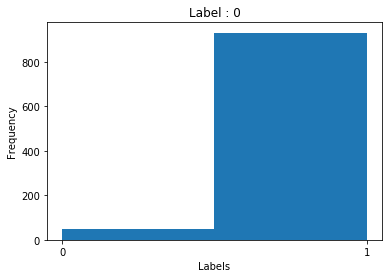

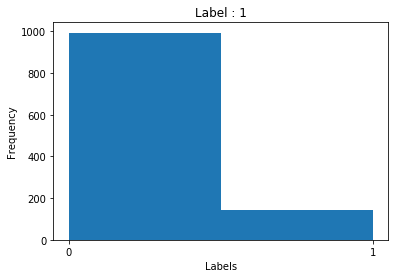

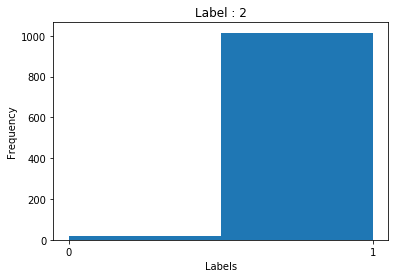

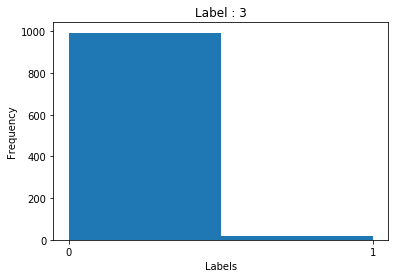

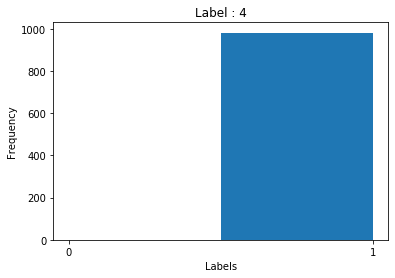

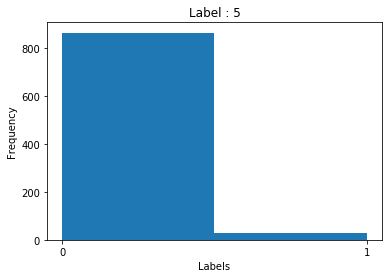

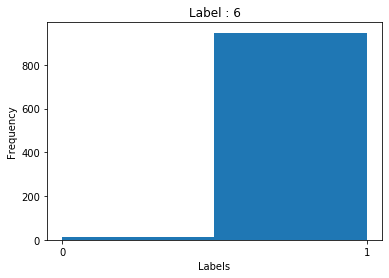

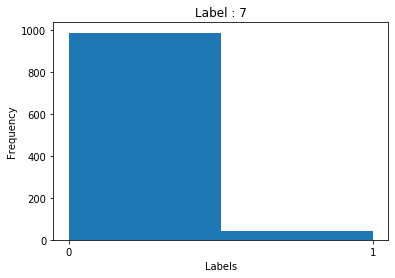

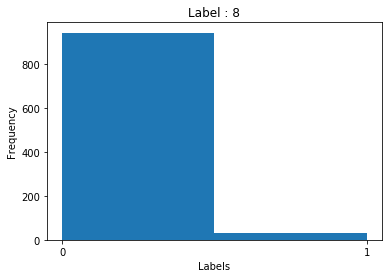

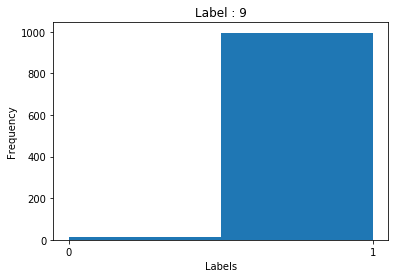

In [41]:
for i in range(10):
    plt.hist(path[path[:, 0] == i, 1], bins=2)
    plt.title("Label : {0}".format(i))
    plt.xticks([0, 1])
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()

In [35]:
path[path[:, 1] == 0, 0]

tensor([3, 5, 8,  ..., 8, 8, 5])

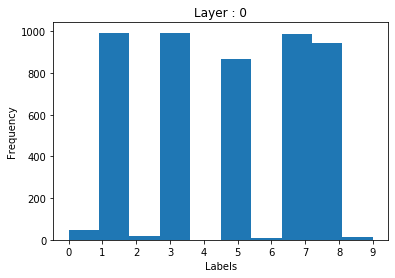

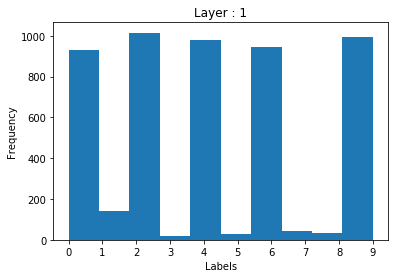

In [40]:
for i in range(2):
    plt.hist(path[path[:, 1] == i, 0], bins=10)
    plt.title("Layer : {0}".format(i))
    plt.xticks([x for x in range(10)])
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()